In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler

Data Size After Cleaning: 755
Test MAE: 4.168396557345332
Test MSE: 63.80700425183327
Test R^2 Score: 0.9676049325140328


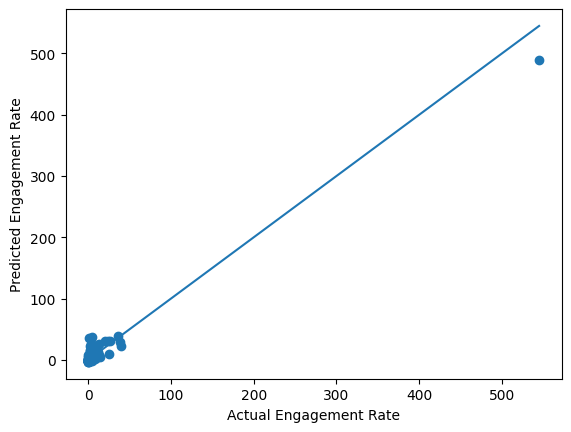

In [25]:
df = pd.read_csv("merged_cleaned.csv")

df_cleaned = df[df["Posting_Frequency(60Days)"] != 0].copy()

q1 = df_cleaned["Posting_Frequency(60Days)"].quantile(0.25)
q3 = df_cleaned["Posting_Frequency(60Days)"].quantile(0.75)
IQR = q3 - q1

df_cleaned = df_cleaned[(df_cleaned["Posting_Frequency(60Days)"] >= q1 - IQR * 1.5) & (df_cleaned["Posting_Frequency(60Days)"] <= q3 + 1.5 * IQR)].copy()
print(f"Data Size After Cleaning: {df_cleaned.shape[0]}")

df_cleaned["Image_Ratio"] = df_cleaned["Posts(Image)"] / df_cleaned["Posting_Frequency(60Days)"]
df_cleaned["Video_Ratio"] = df_cleaned["Posts(Video)"] / df_cleaned["Posting_Frequency(60Days)"]
df_cleaned["Carousel_Ratio"] = df_cleaned["Posts(Carousel)"] / df_cleaned["Posting_Frequency(60Days)"]
df_cleaned["Like_Comment_Ratio"] = df_cleaned["Average_Likes"] / df_cleaned["Average_Comments"]

df_cleaned["Logged_Likes"] = np.log(df_cleaned["Average_Likes"])

x = df_cleaned[["Followers", "Logged_Likes", "Average_Comments", "Average_Engagement_Rate", "Posting_Frequency(60Days)", "Posts(Image)", "Posts(Video)", "Posts(Carousel)", "Average_Hashtags(60Days)", "Image_Ratio", "Video_Ratio", "Carousel_Ratio", "Like_Comment_Ratio"]]
y = df_cleaned[["Average_Engagement_Rate(60Days)"]]


scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

model = Ridge()

param_grid = {
    "alpha": [0.1, 1, 10, 100, 1000],
    "max_iter": [1000, 2000, 3000, 5000, 10000],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_

y_predict = best_model.predict(x_test)

mean_absolute_error_value = mean_absolute_error(y_test, y_predict)
mean_squared_error_value = mean_squared_error(y_test, y_predict)
r2_score_value = r2_score(y_test, y_predict)
print(f"Test MAE: {mean_absolute_error_value}\nTest MSE: {mean_squared_error_value}\nTest R^2 Score: {r2_score_value}")

plt.scatter(y_test, y_predict)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], label="Regression Line")
plt.xlabel("Actual Engagement Rate")
plt.ylabel("Predicted Engagement Rate")
plt.show()